# Performing combined approximation, continuity and energy objective optimization experiments

In this Jupyter notebook we perform first tests in the combined $C^k$- ,approximation and energy loss optimization setting. 

Version 0.1  
Date: 2025-02-21  
Current version: hannes.waclawek@fh-salzburg.ac.at  

In [49]:
import copy

# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import multiprocessing as mp
from itertools import repeat

from tfspline import model, parallel, plot, sampledata

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Energy minimization

In order to reduce the forces applied to a cam-follower system, we want to optimize the cam's acceleration curve.
To do so, we can quantify total curvature as

\begin{align*}
    \int_I f''(x)^2 \; \mathrm{d}x
\end{align*}

for a cam profile $f$ over the interval $I$.
Considering our individual polynomial segments $p_i$, we receive

\begin{align*}
    \int_I f''(x)^2 \; \mathrm{d}x
      &= \sum_{i=1}^m \int_{I_i} p''_i(x)^2 \; \mathrm{d}x
\end{align*}

with
\begin{align*}
    & \int_{I_i} p''_i(x)^2 \; \mathrm{d}x \\
    &= \int_{I_i} \left( \sum_{j=2}^d \alpha_{i,j} \cdot j (j-1) x^{j-2} \right)^2  \; \mathrm{d}x \\
    %&= \int_{I_i} \left( \sum_{j=2}^d \alpha_{i,j} \cdot j (j-1) x^{j-2} \right) \cdot \\
    %&  \quad \left( \sum_{k=2}^d \alpha_{i,k} \cdot k (k-1) x^{k-2} \right) \; \mathrm{d}x \\
    &= \sum_{j=2}^d \sum_{k=2}^d \alpha_{i,j} \alpha_{i,k} j k (j-1) (k-1) \cdot
        \int_{I_i} x^{j+k-4} \; \mathrm{d}x \\
    &= \sum_{j=2}^d \sum_{k=2}^d \frac{\alpha_{i,j} \alpha_{i,k} j k (j-1) (k-1)}{j+k-3}
        \cdot \left. x^{j+k-3} \right|_{\xi_{i-1}}^{\xi_i}
\end{align*}

representing total acceleration for each individual polynomial segment.
Plugging in the boundary points for the definite integral and generalizing 
to the overall spline with $m$ segments we can then formulate total curvature loss as 

\begin{align*}
    \ell_\text{E} = \sum_{i=1}^m \sum_{j=2}^d \sum_{k=2}^d \alpha_{i,j} \alpha_{i,k} \frac{j k (j-1) (k-1)}{j+k-3}
        \cdot \left(\xi_i^{j+k-3}-\xi_{i-1}^{j+k-3}\right). \\
\end{align*}

# 3-objective optimization

Previously, we optimized for continuity error $\ell_{\text{CK}}$ and approximation error $\ell_2$ utilizing the loss function

\begin{align}
    \ell = \alpha \ell_{\text{CK}} + (1-\alpha) \ell_2,
\end{align}

with $0 \le \alpha \le 1$. 

We now have three objectives, $\ell_2, \ell_{\text{CK}}, \ell_{\text{E}}$,
and still want to weight them in a way that the sum of the weights equals $1$.  
Therefore, we introduce two independent parameters \( \alpha \) and \( \beta \),
and define the weighted sum as:  

\begin{align}
    \ell = \alpha \ell_{\text{CK}} + \beta \ell_2 + (1-\alpha-\beta) \ell_{\text{E}},
\end{align}

where $\alpha, \beta \geq 0$ and $\alpha + \beta \leq 1$.  
   
- $\alpha$ controls the emphasis on $\ell_{\text{CK}}$  
- $\beta$ controls the emphasis on $\ell_2$  
- The remaining weight $(1 - \alpha - \beta)$ is assigned to $\ell_{\text{E}}$ 
- If $\alpha + \beta = 1$, then $\ell_{\text{E}}$  has no weight  
- If $\alpha + \beta = 0$, then only $\ell_{\text{E}}$ is considered  

# What we know from previous findings

## General

Continuity optimization works and results converge.

## Alpha

We increase alpha with rising variance as more emphasis on continuity optimization is required:
- Simple rise: 0.1
- Sine: 0.1
- Sine with varying frequency: 0.6
- Noisy Sine with varying frequency: 0.999

## Learning rate and number of epochs  
 
Contrary to the single approximation target we see that a lower learning rate of 0.1 is beneficial.
Also contrary to the single approximation target, the combined C^k and approximation goal now leads to a non-convex loss landscape
and we see spikes in the loss curve at some epoch ranges. This is expected, if optimization leaves a local optima towards a lower optimum.
Early stopping and reverting to the best loss / coefficients of the training cycle can prevent ending up with an unsatisfiable local optimum result.

**A learning rate of 0.1 seems to be a reasonable choice for all bases.**
**2000 epochs seem to be sufficient. With early stopping we can have less.**
  
## Number of polynomials
  
Raising the number of polynomials, as expected, reduces remaining losses and, for Chebyshev basis, shows less spikes in remaining losses.
If we increase the number of segments, the variance in the individual segments input data is effectively decreased.  
A learning rate of 0.1 still is good for more polynomials. 

## Optimizers  
  
Chebyshev basis is clearly outperforming Power Basis in regard to all observed optimizers and input point sets.
**None of the optimizers manage to surpass the l2 optimum with Power basis in the given 5000 epochs for the lowest variance input data (name in this notebook: Simple rise curve).**
**There are, however, several optimizers that achieve this with Chebyshev basis.**
The more variance is in the input data, the higher is the loss for the l2 baseline with CK loss.
The more variance is in the input data, the more optimizers (also with Power basis) manage to surpass this l2 baseline.
The following optimizer candidates surpass the l2 baseline with all observed input data:
1. adam, amsgrad
2. adamax
3. adagrad, ftrl
4. nadam

Considering all observed input data, Adam AMSGrad is the best candidate.
With least squares fit initialization of polynomial coefficients, Power basis gets competitive again.
However, Chebyshev basis with AMSGrad still shows the best convergence behaviour also in that scenario.

## AMSGrad optimizer parameters

Default parameters perform best for Power and Chebyshev basis.

## $C^k$ loss regularization

Results with $C^k$ loss regularization outperform results without $C^k$ loss regularization for all candidate optimizers.
The more variance is in the input data, the closer is the gap. 


## Data


Text(0.5, 1.0, 'Scaled to range [0, 2] for 2 polynomial segments')

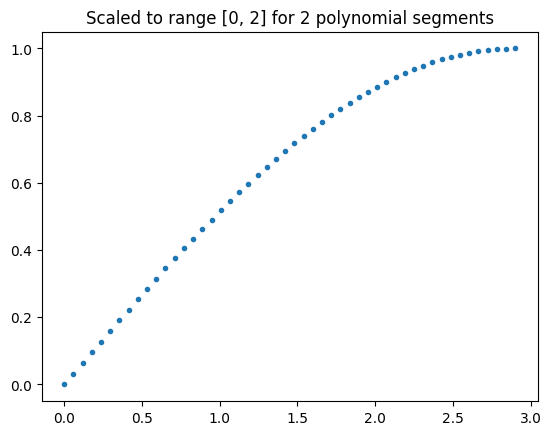

In [50]:
# The data set to approximate with x and y samples
xs2_ori = np.linspace(0, 0.5*np.pi, 50)
ys2 = np.sin(xs2_ori)
#plt.plot(xs2_ori, ys2, '.')
xs2 = sampledata.rescale_input_data(xs2_ori, 2.9)
plt.plot(xs2, ys2, '.')
plt.title('Scaled to range [0, 2] for 2 polynomial segments')

Text(0.5, 1.0, 'Scaled to range [0, 4] for 4 polynomial segments')

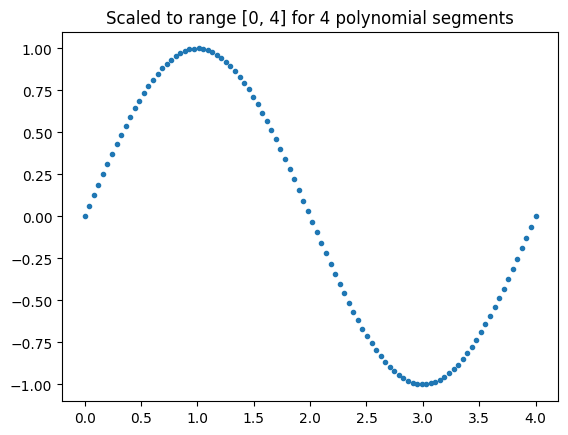

In [51]:
xsin = np.linspace(0, 2*np.pi, 100)
ysin = np.sin(xsin)
xsin = sampledata.rescale_input_data(xsin, 4)

plt.plot(xsin, ysin, '.')
plt.title('Scaled to range [0, 4] for 4 polynomial segments')

Text(0.5, 1.0, 'Scaled to range [0, 10] for 10 polynomial segments')

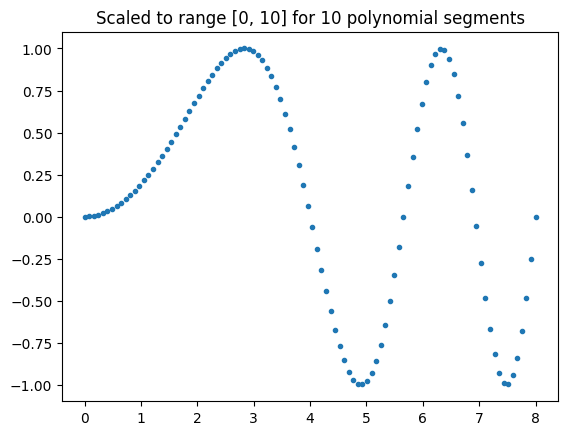

In [52]:
xsinvar = np.linspace(0, 1, 100)
ysinvar = np.sin(xsinvar**2 * 4 * np.pi)
xsinvar = sampledata.rescale_input_data(xsinvar, 8)

plt.plot(xsinvar, ysinvar, '.')
plt.title('Scaled to range [0, 10] for 10 polynomial segments')

Text(0.5, 1.0, 'Scaled to range [0, 2] for 2 polynomial segments')

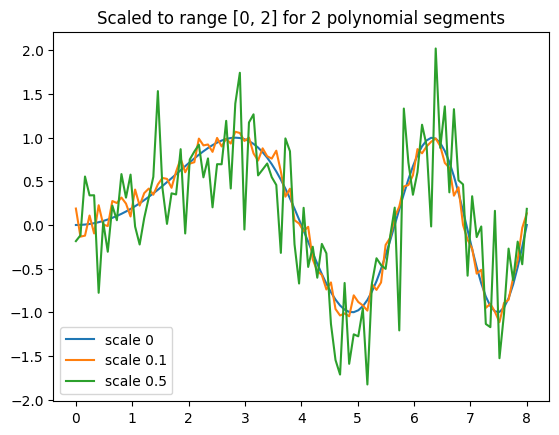

In [53]:
# Explicit seed to have reproducible testsets
np.random.seed(0)
ys2gauss_scales = [0.0, 0.1, 0.5]
ys2gauss = [ysinvar + np.random.normal(scale=s, size=len(ysinvar)) for s in ys2gauss_scales]

for i, ysn in enumerate(ys2gauss):
    plt.plot(xsinvar, ysn, '-', label='scale %.2g' % ys2gauss_scales[i])
plt.legend(loc="best")
plt.title('Scaled to range [0, 2] for 2 polynomial segments')

## First tests: Single segment

For a single segment,$\ell_{\text{CK}}=0$.
Here, we use $\alpha$ to control emphasis on $\ell_{\text{E}}$.

In [54]:
ck = 0
polynum=1
degree = 7
learning_rate = 0.1

### Without energy optimization

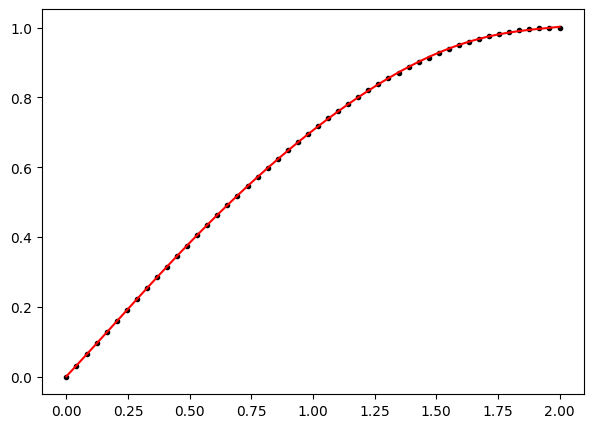

In [55]:
alpha = 0
beta = 1-alpha

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

pp.fit(xs2, ys2, optimizer=opt, n_epochs=600, factor_ck_pressure=0, factor_approximation_quality=beta, factor_curvature=alpha, early_stopping=True, patience=100)
plot.plot_spline(pp)

In [56]:
pp.get_total_loss()

<tf.Tensor: shape=(), dtype=float64, numpy=0.34322460950961914>

In [57]:
pp.initialization

'zero'

### With energy optimization

Early stop: Achieved best result after 54 epochs. Exiting.


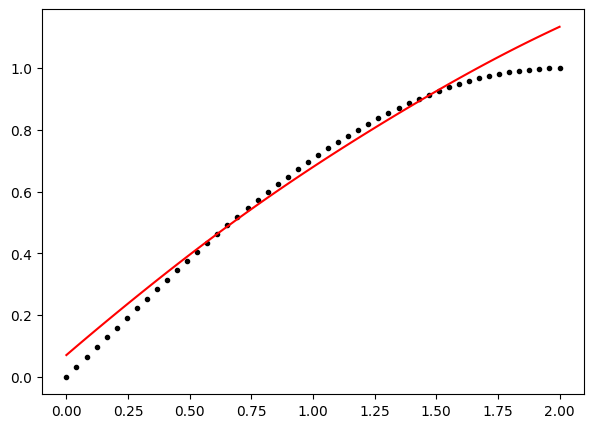

In [58]:
alpha = 0.01
beta = 1-alpha

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

pp.fit(xs2, ys2, optimizer=opt, n_epochs=600, factor_ck_pressure=0, factor_approximation_quality=beta, factor_curvature=alpha, early_stopping=True, patience=100)
plot.plot_spline(pp)

Early stop: Achieved best result after 79 epochs. Exiting.


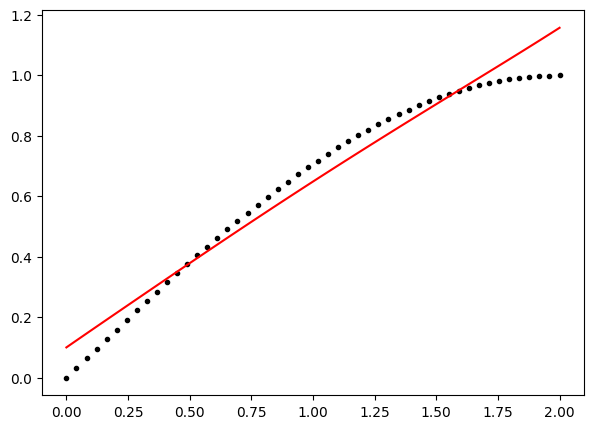

In [59]:
alpha = 0.1
beta = 1-alpha

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

pp.fit(xs2, ys2, optimizer=opt, n_epochs=600, factor_ck_pressure=0, factor_approximation_quality=beta, factor_curvature=alpha, early_stopping=True, patience=100)
plot.plot_spline(pp)

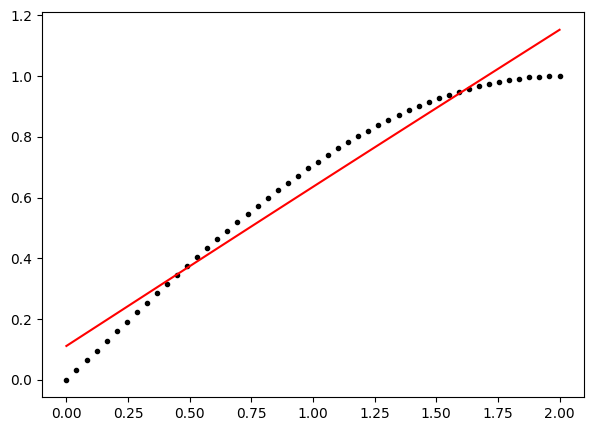

In [60]:
alpha = 0.5
beta = 1-alpha

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

pp.fit(xs2, ys2, optimizer=opt, n_epochs=600, factor_ck_pressure=0, factor_approximation_quality=beta, factor_curvature=alpha, early_stopping=True, patience=100)
plot.plot_spline(pp)

Early stop: Achieved best result after 146 epochs. Exiting.


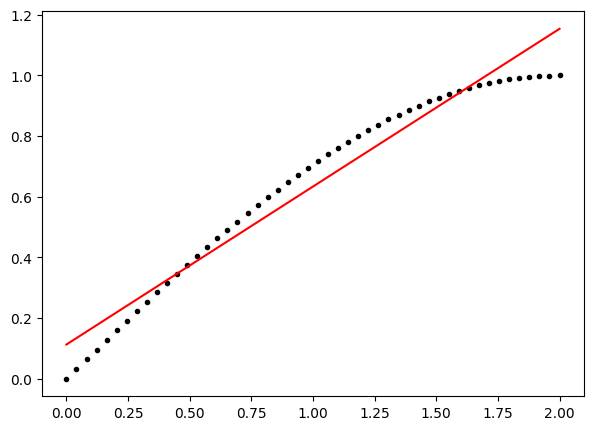

In [61]:
alpha = 0.9
beta = 1-alpha

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

pp.fit(xs2, ys2, optimizer=opt, n_epochs=600, factor_ck_pressure=0, factor_approximation_quality=beta, factor_curvature=alpha, early_stopping=True, patience=100)
plot.plot_spline(pp)

Early stop: Achieved best result after 1 epochs. Exiting.


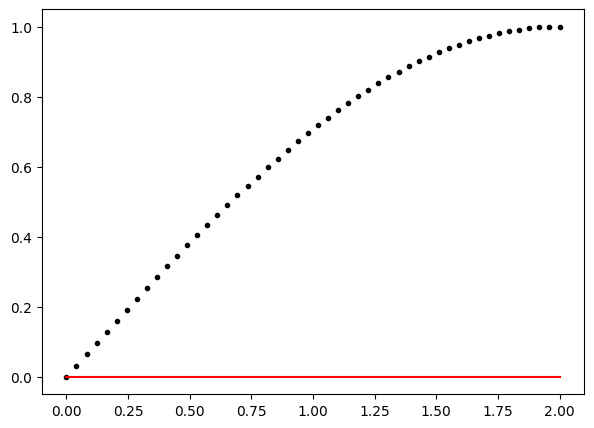

In [62]:
alpha = 1.0
beta = 1-alpha

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

pp.fit(xs2, ys2, optimizer=opt, n_epochs=600, factor_ck_pressure=0, factor_approximation_quality=beta, factor_curvature=alpha, early_stopping=True, patience=100)
plot.plot_spline(pp)

### Interpretation

We can see how the result is "flattened" by the energy loss term, since curvature is penalized.  
This 2-objective optimization task reduces to the one of fitting a straight line to a set of points.  
"Out of the possible function degrees to choose from, only consider degree 1."  

## First tests: Two segments

We now have three objectives, $\ell_2, \ell_{\text{CK}}, \ell_{\text{E}}$, weighted as:  

\begin{align}
    \ell = \alpha \ell_{\text{CK}} + \beta \ell_2 + (1-\alpha-\beta) \ell_{\text{E}},
\end{align}

In [63]:
ck = 3
polynum=2
degree = 7
learning_rate = 0.1

In [91]:
alpha = 0.1
beta = 0.9
epochs=600

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

pp.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_ck_pressure=alpha, factor_approximation_quality=beta, factor_curvature=1-alpha-beta, early_stopping=True, patience=100)
loss = pp.get_total_loss()

/home/hannes/Documents/FHGitRepos/venvs/energyopt-pp/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


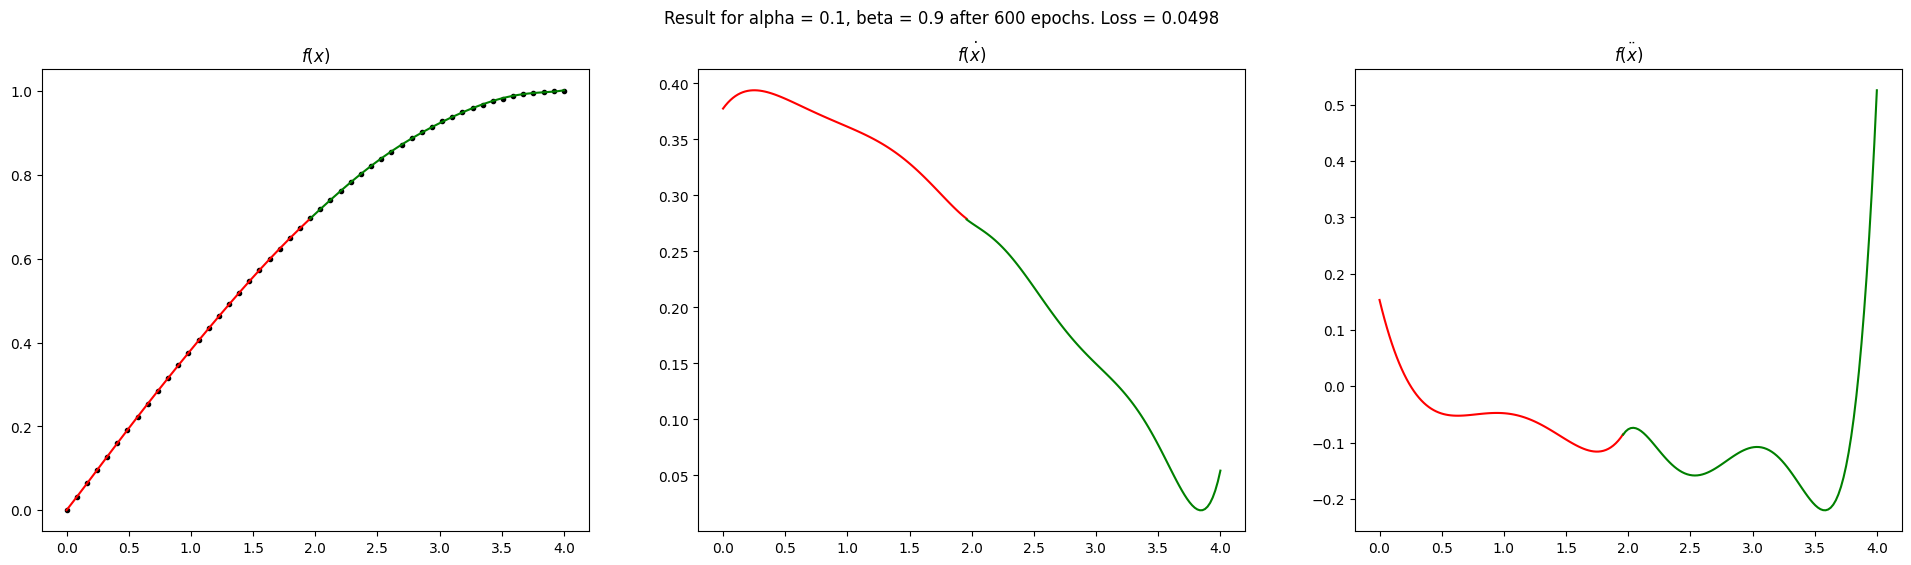

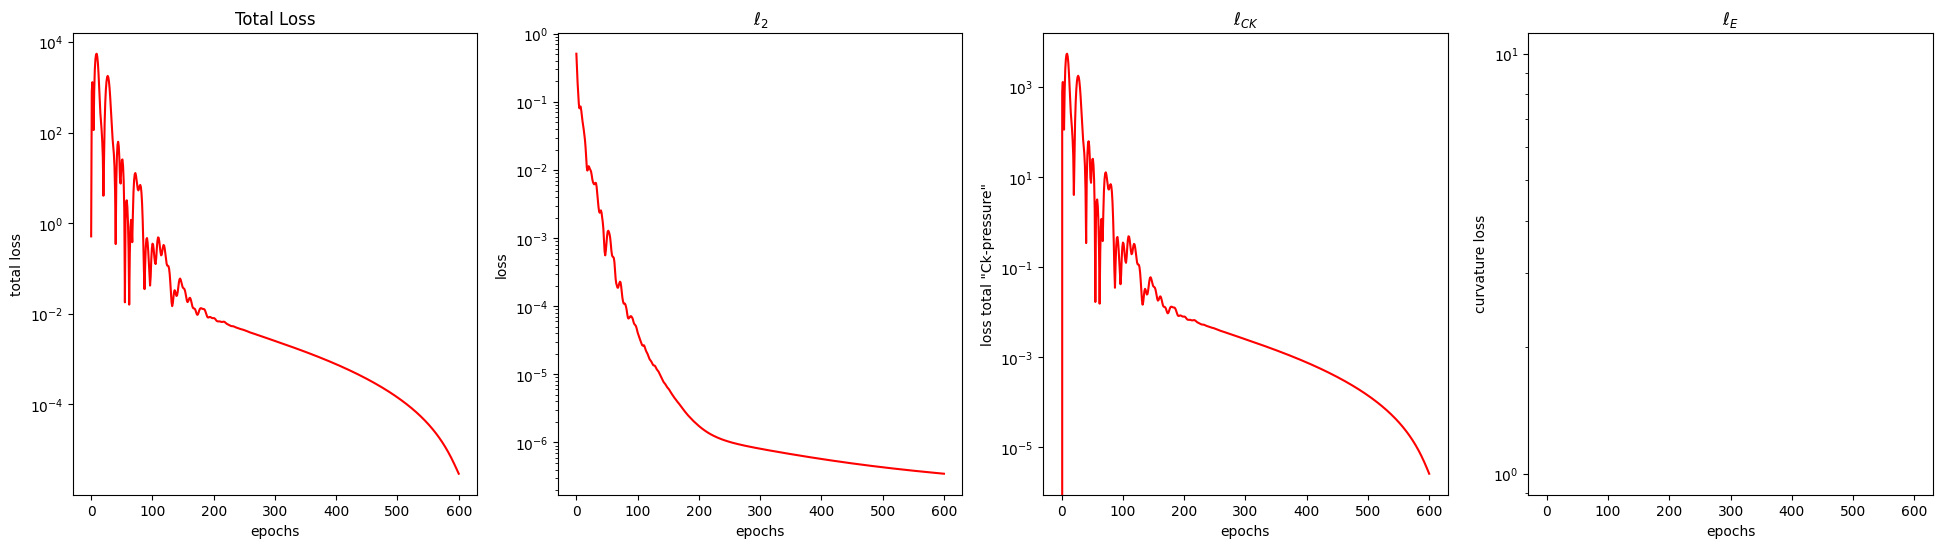

In [92]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')
plot.plot_loss(pp, 'all')

In [66]:
alpha = 0.1
beta = 0.89
epochs=600

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

loss = pp.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_ck_pressure=alpha, factor_approximation_quality=beta, factor_curvature=1-alpha-beta, early_stopping=True, patience=100)

Early stop: Achieved best result after 89 epochs. Exiting.


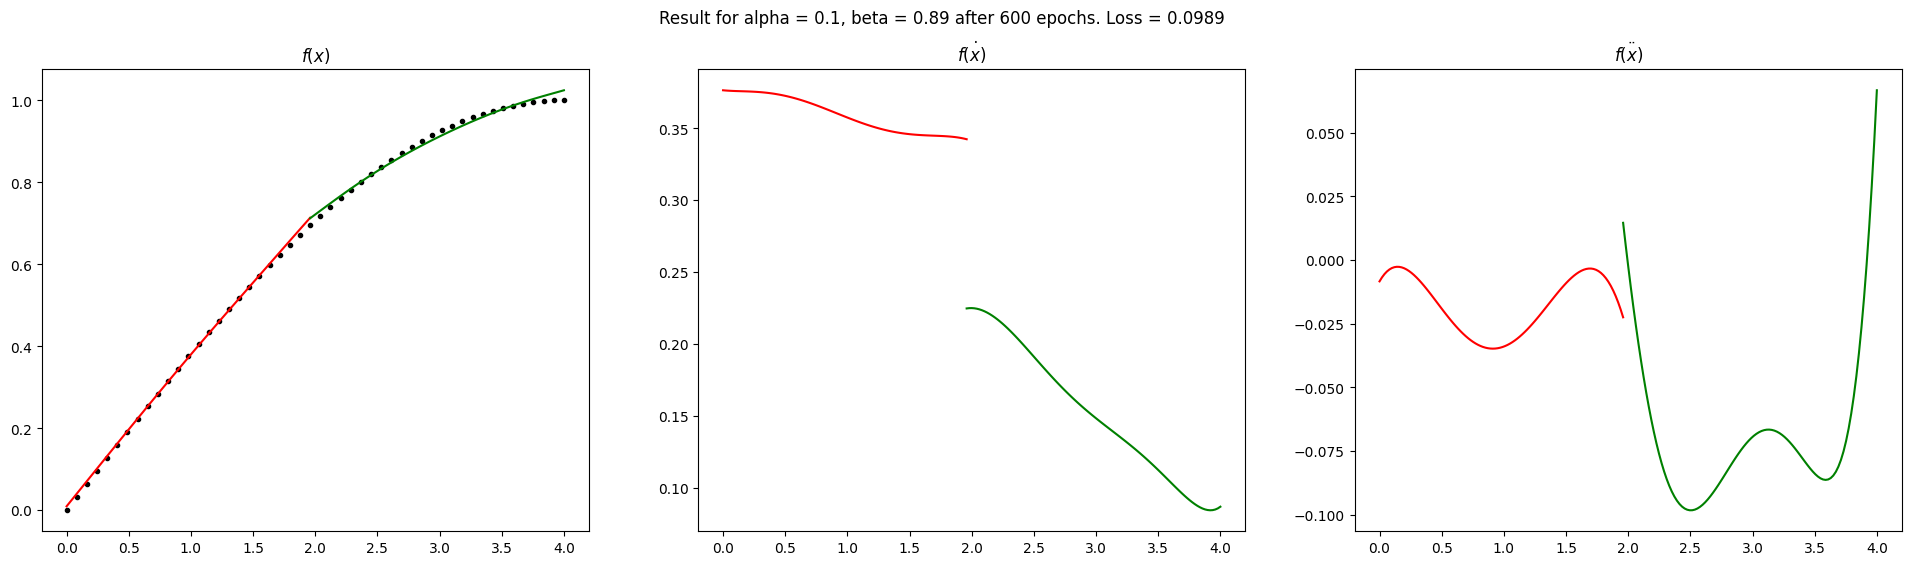

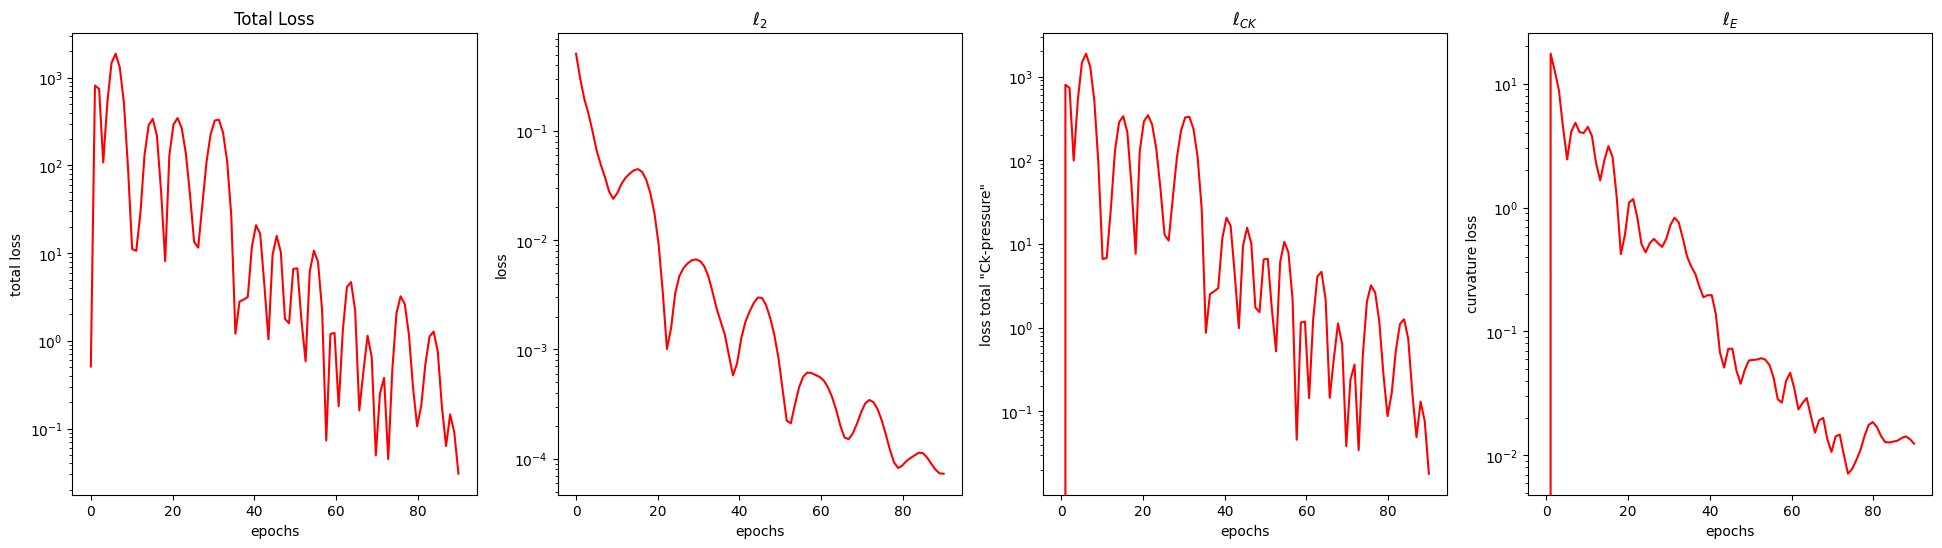

In [67]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')
plot.plot_loss(pp, 'all')

### Interpretation

The energy loss term is counteracting both the approximation and continuity target.  
We see how each segment is flattened individually, since curvature is penalized.  
Continuity in the first derivative is still met, wile it is not in higher derivatives.  
Does this indicate higher derivatives need more priorization?  
What if we don't regularize CK optimization then?  

In [68]:
alpha = 0.1
beta = 0.89
epochs=600

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

loss = pp.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_ck_pressure=alpha, factor_approximation_quality=beta, factor_curvature=1-alpha-beta, early_stopping=True, patience=100, ck_regularization=False)

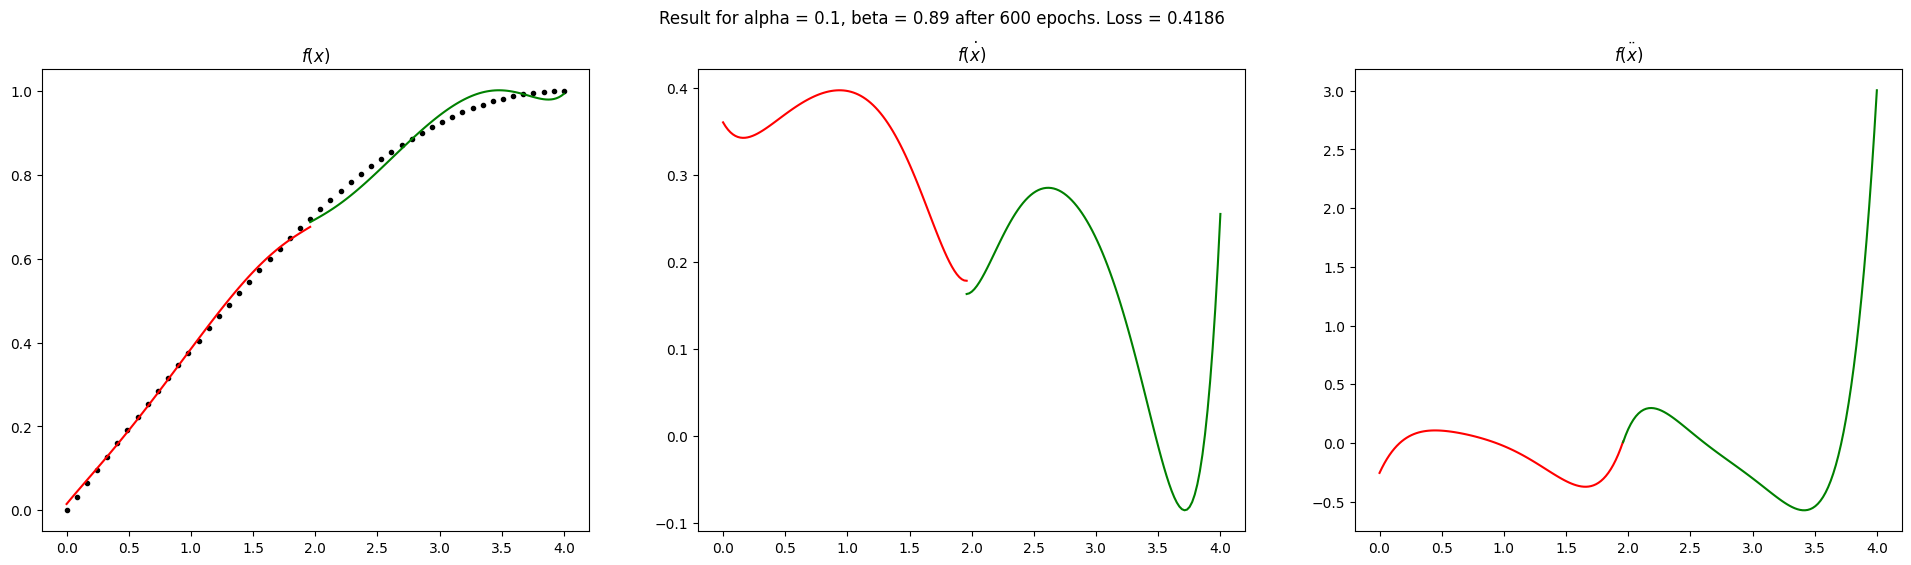

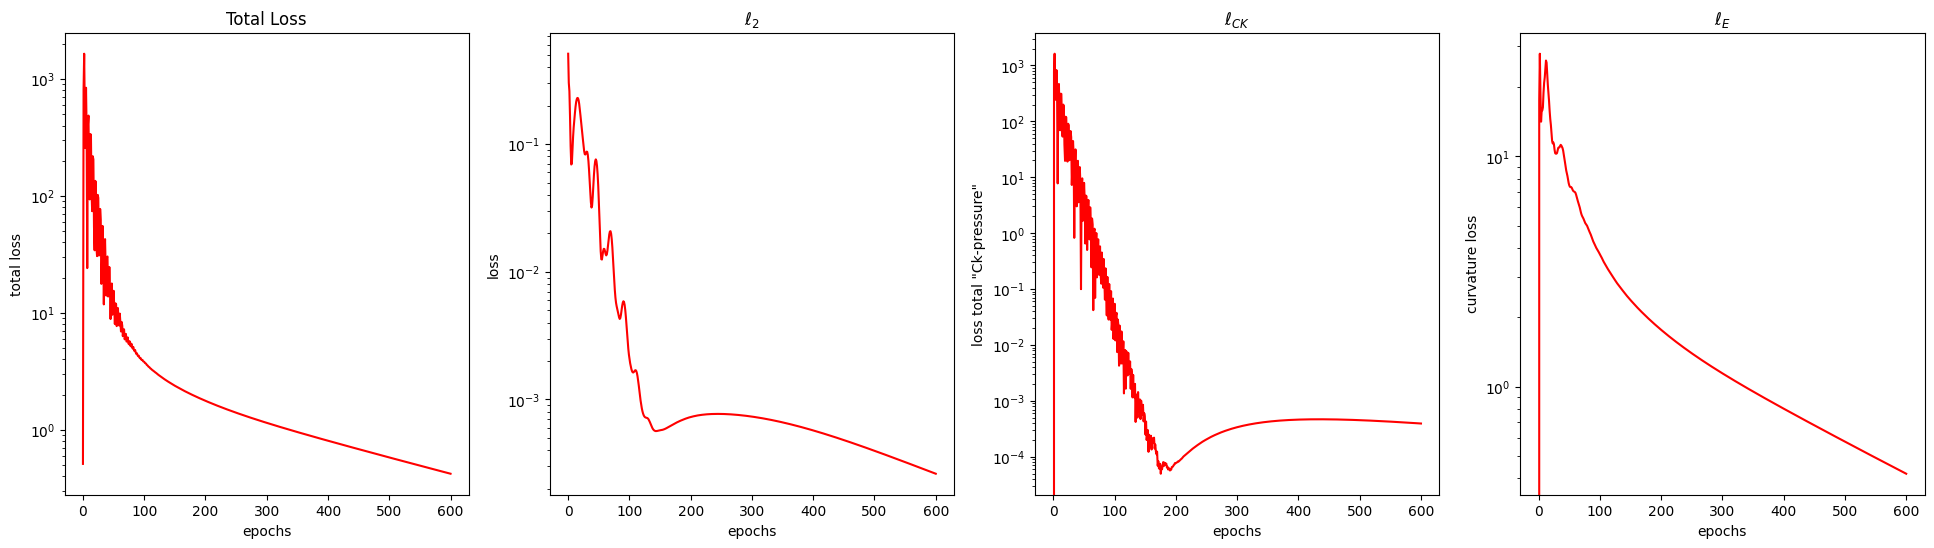

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')
plot.plot_loss(pp, 'all')

There's more oscillating behaviour, but higher derivatives seem to align better now.  
Do we need more epochs?  

In [70]:
alpha = 0.1
beta = 0.89
epochs = 10000

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

loss = pp.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_ck_pressure=alpha, factor_approximation_quality=beta, factor_curvature=1-alpha-beta, early_stopping=True, patience=100, ck_regularization=False)

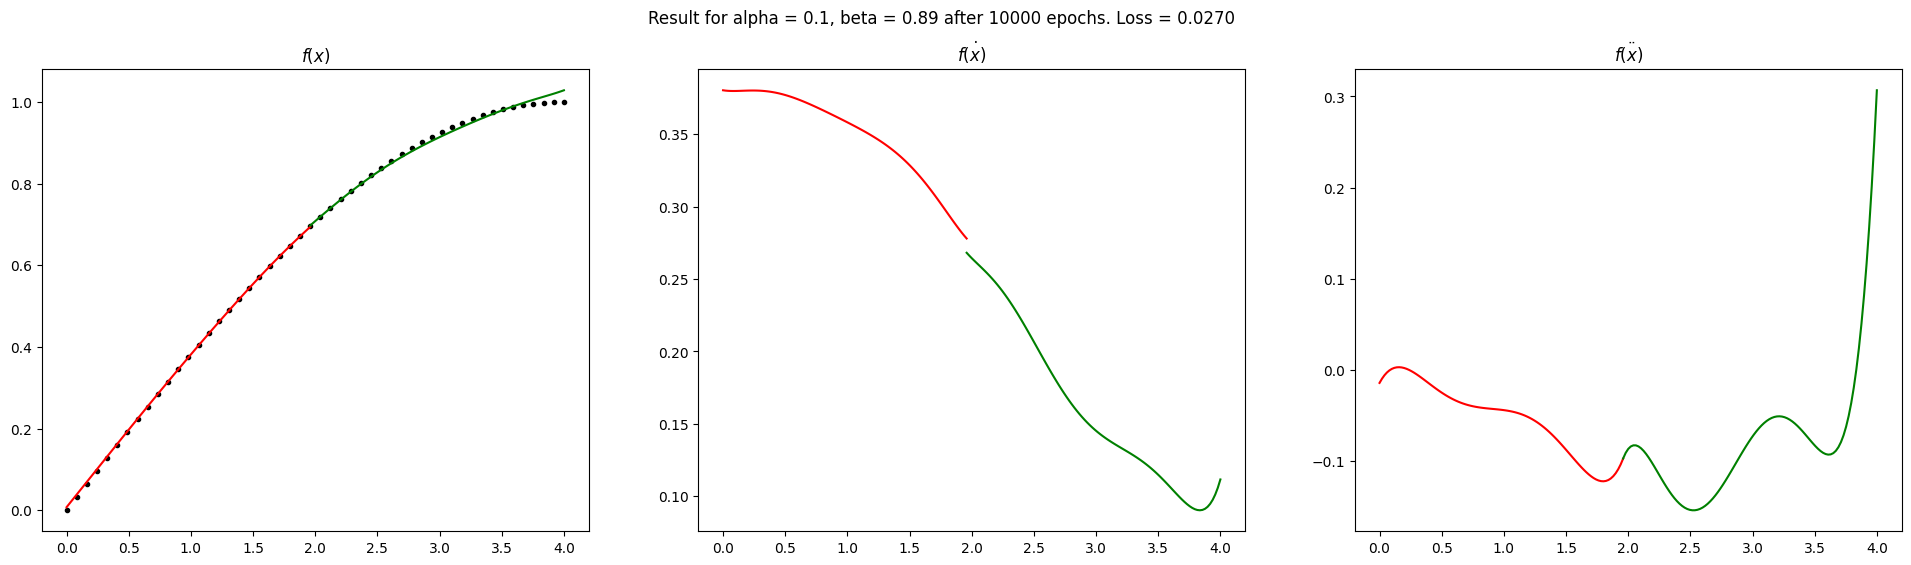

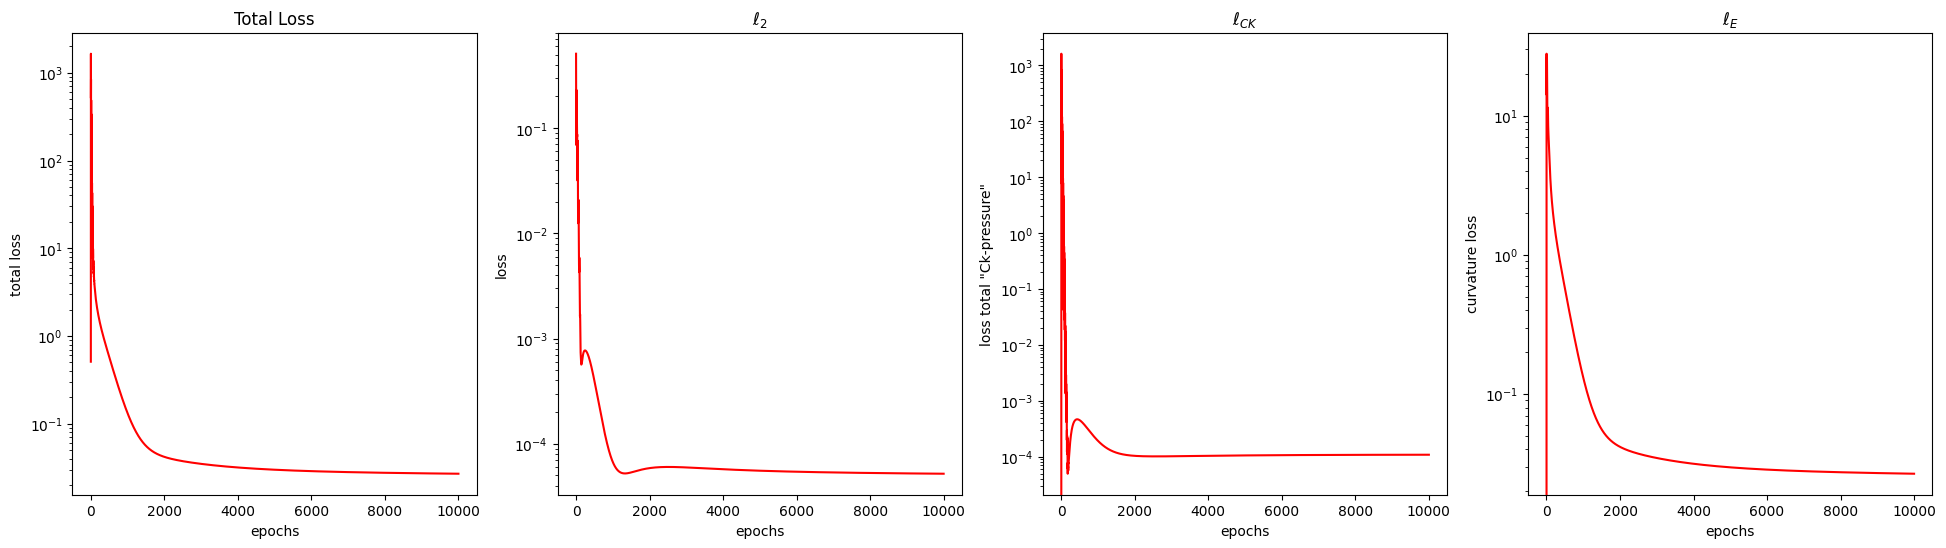

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')
plot.plot_loss(pp, 'all')

In [72]:
pp._establish_continuity()
loss = pp.get_total_loss()

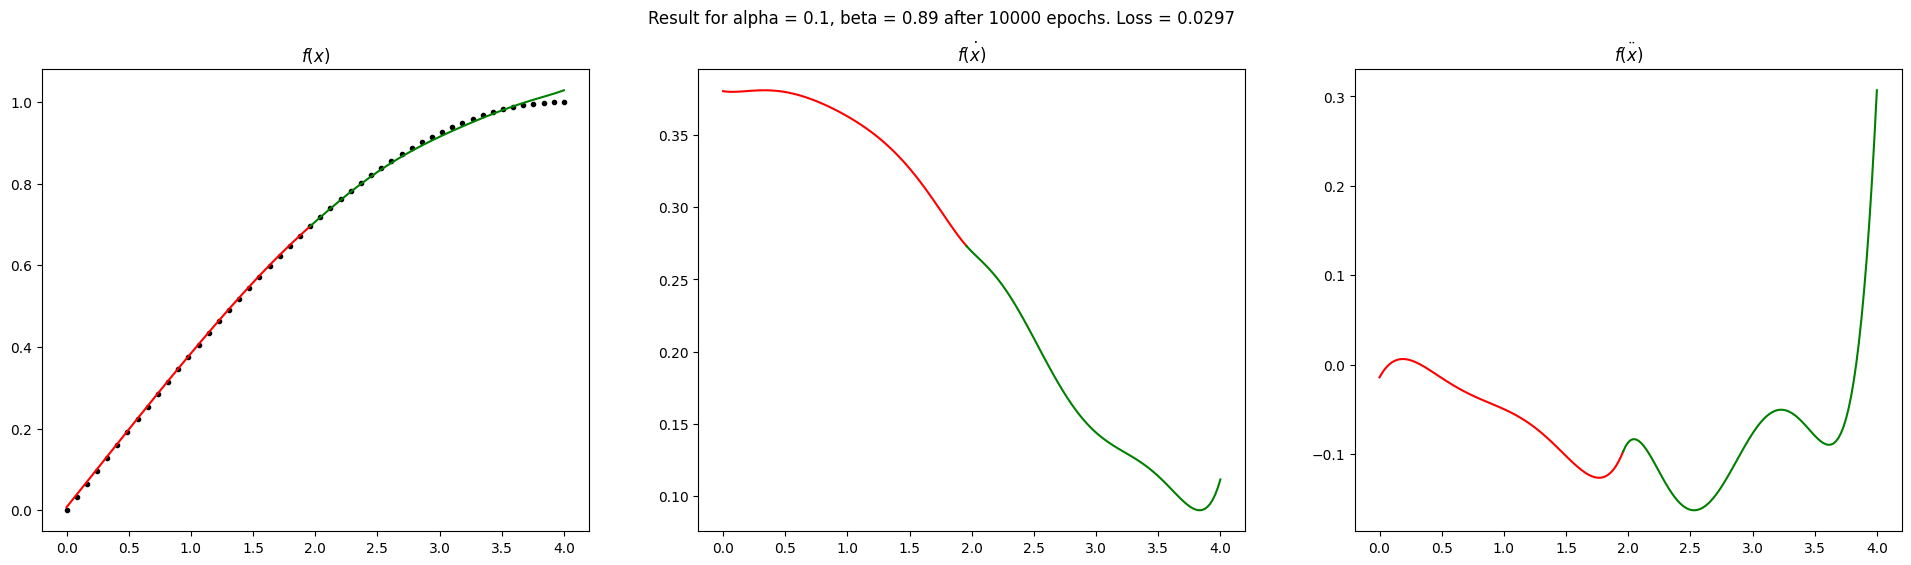

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')

### Interpretation

Lower remaining loss with less curvature.  
After strictly establishing continuity, result is very acceptable.  
What about more epochs with CK-regularization enabled?  

In [74]:
alpha = 0.1
beta = 0.89
epochs=10000

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

loss = pp.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_ck_pressure=alpha, factor_approximation_quality=beta, factor_curvature=1-alpha-beta, early_stopping=True, patience=100, ck_regularization=True)

Early stop: Achieved best result after 89 epochs. Exiting.


Stuck in local optimum, disabling early stopping...

In [75]:
alpha = 0.1
beta = 0.89
epochs=10000

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='power')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

loss = pp.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_ck_pressure=alpha, factor_approximation_quality=beta, factor_curvature=1-alpha-beta, early_stopping=False, ck_regularization=True)

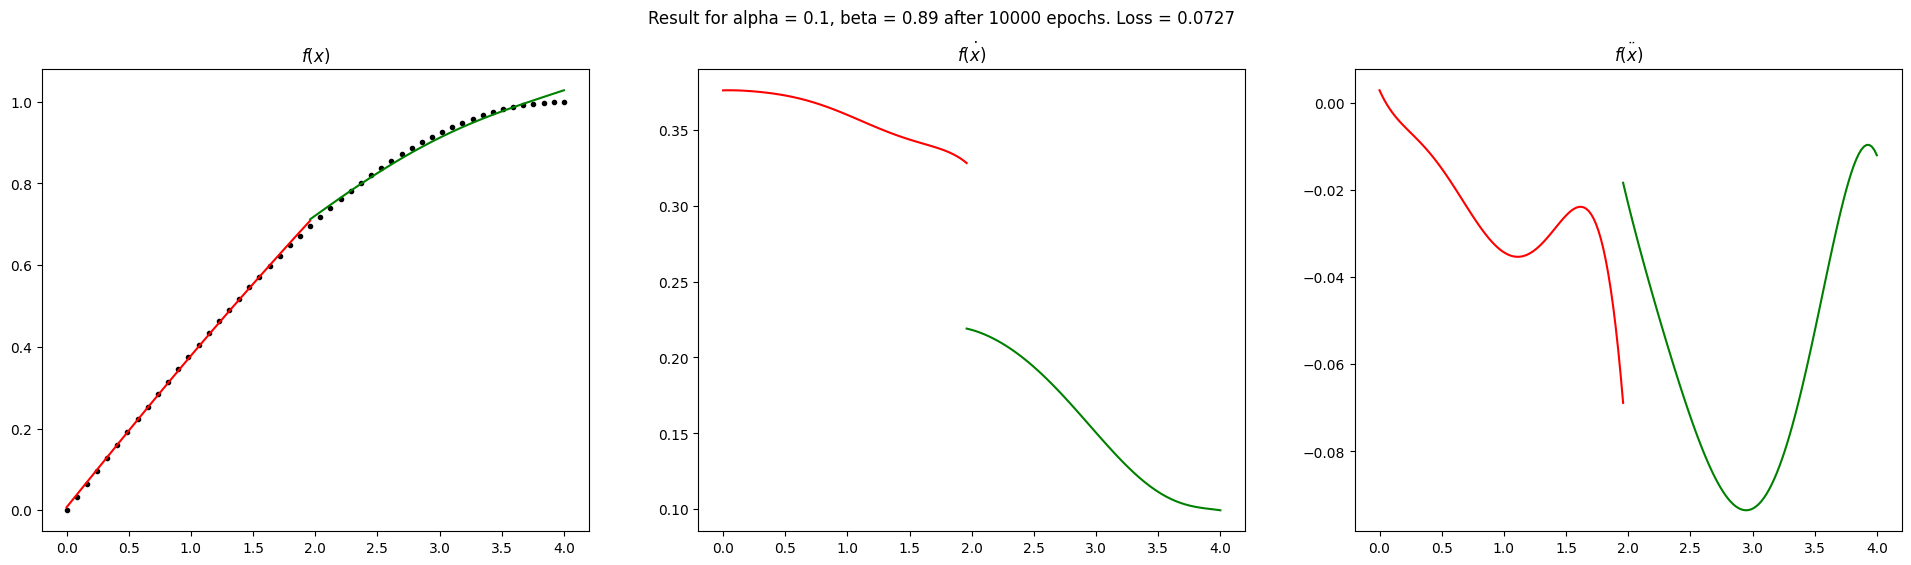

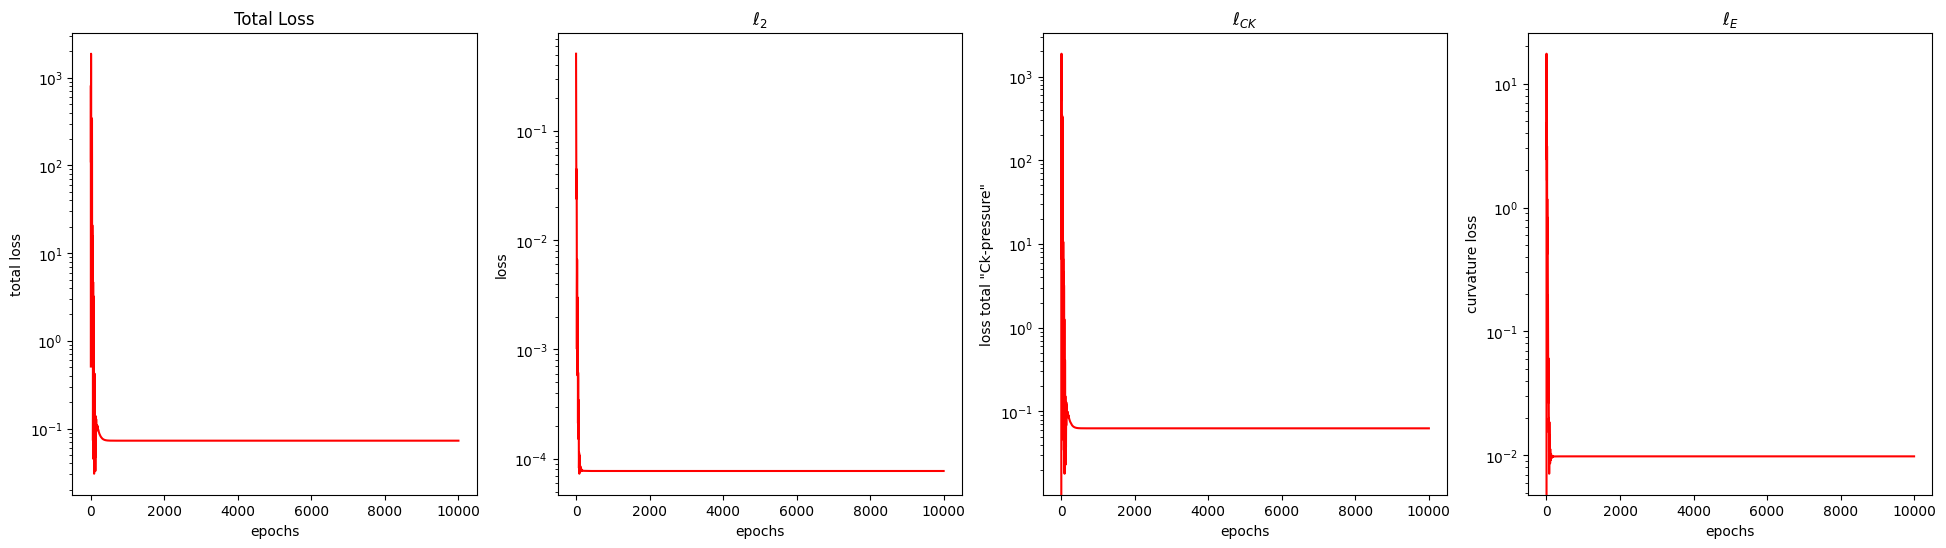

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')
plot.plot_loss(pp, 'all')

In [77]:
pp._establish_continuity()
loss = pp.get_total_loss()

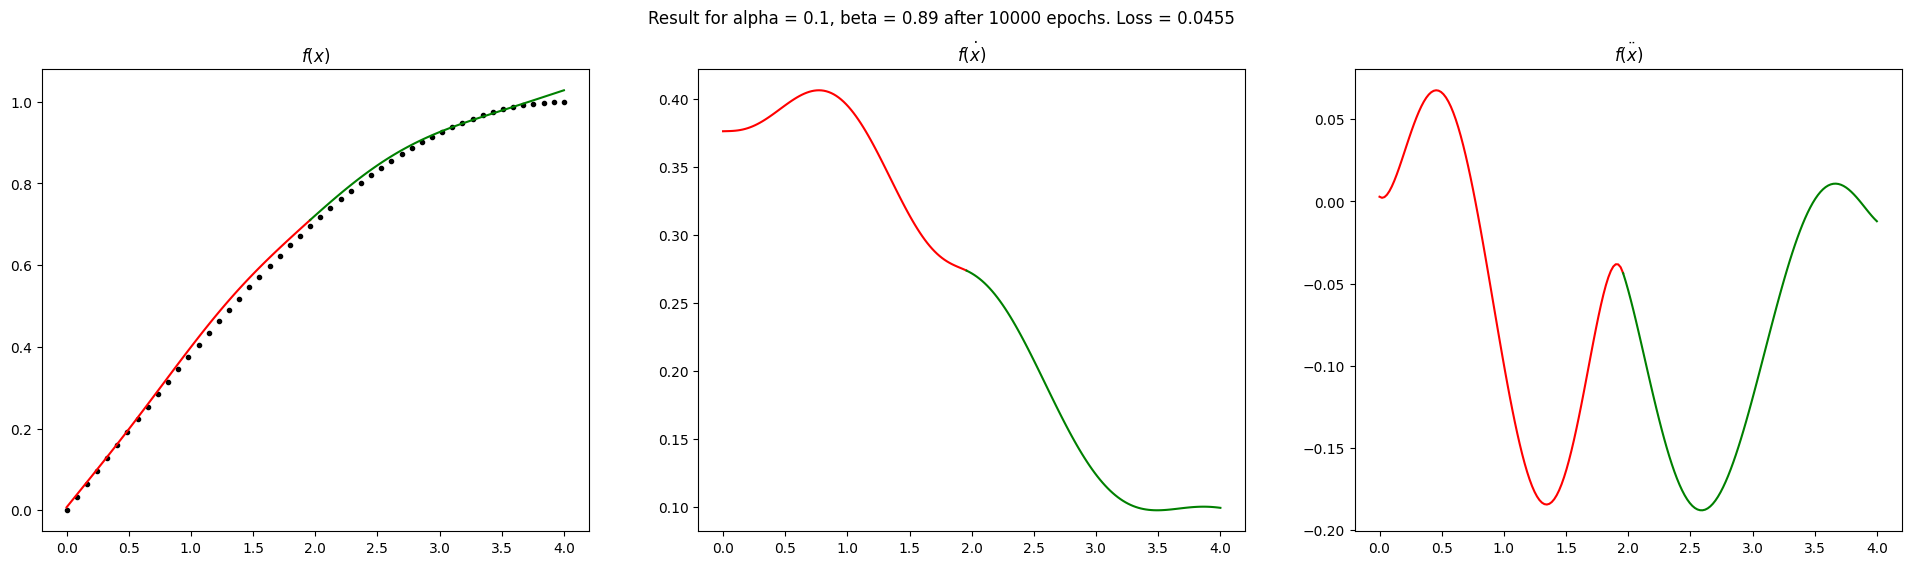

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')

### Interpretation

For Power Basis, disabling Ck-regularization might provide better results.

## Re-test for Chebyshev basis

In [89]:
alpha = 0.1
beta = 0.9
epochs=600

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='chebyshev')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

pp.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_ck_pressure=alpha, factor_approximation_quality=beta, factor_curvature=1-alpha-beta, early_stopping=True, patience=100)
loss = pp.get_total_loss()

/home/hannes/Documents/FHGitRepos/venvs/energyopt-pp/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


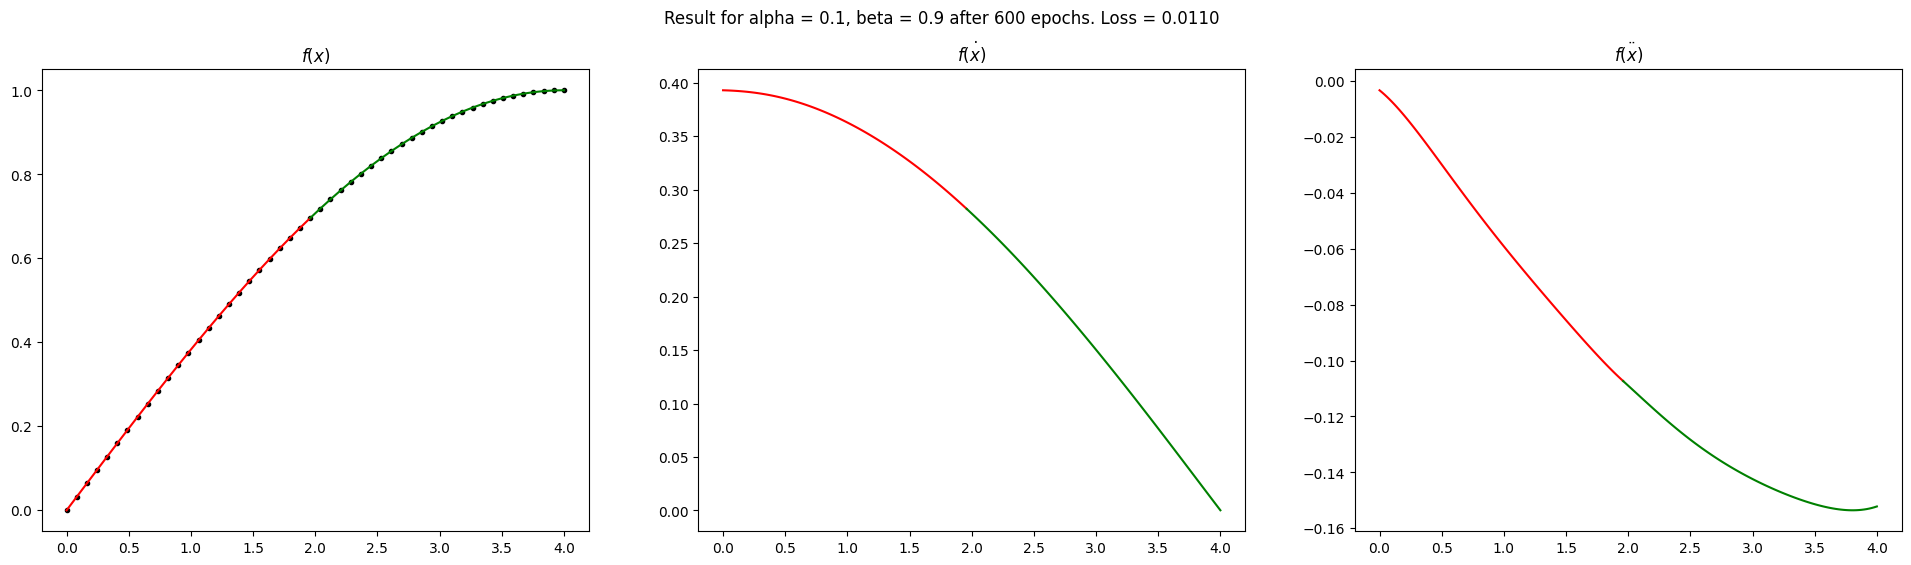

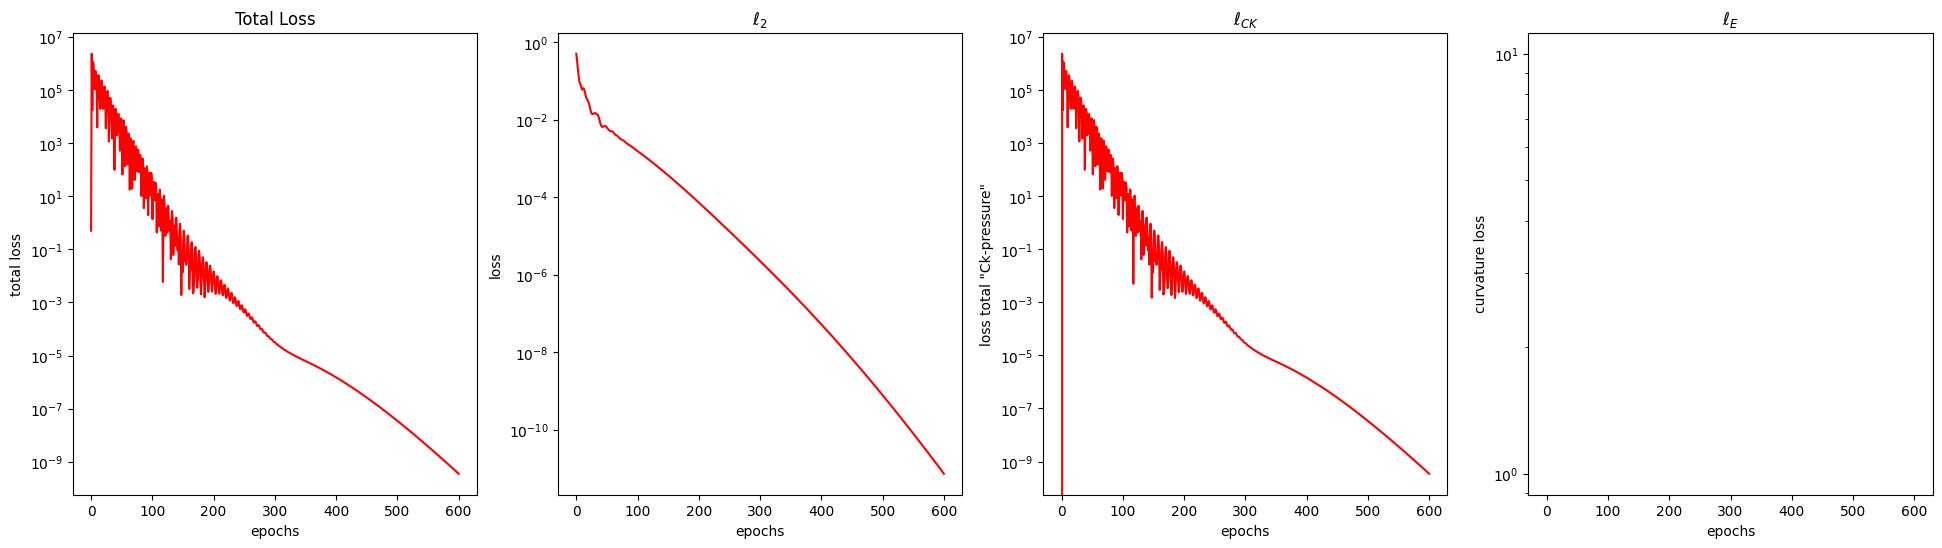

In [90]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')
plot.plot_loss(pp, 'all')

In [81]:
alpha = 0.1
beta = 0.89
epochs=10000

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='chebyshev')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

loss = pp.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_ck_pressure=alpha, factor_approximation_quality=beta, factor_curvature=1-alpha-beta, early_stopping=True, patience=1000)

Early stop: Achieved best result after 172 epochs. Exiting.


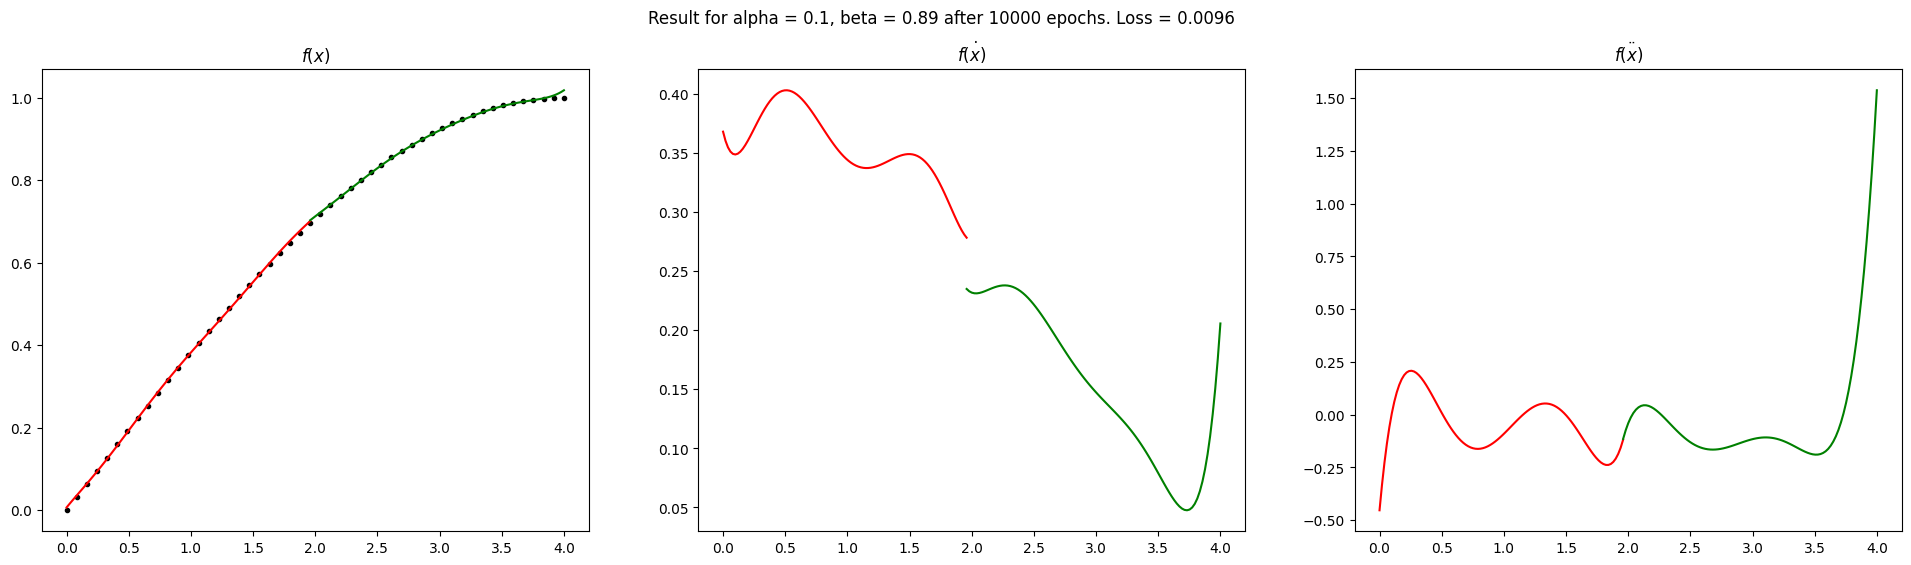

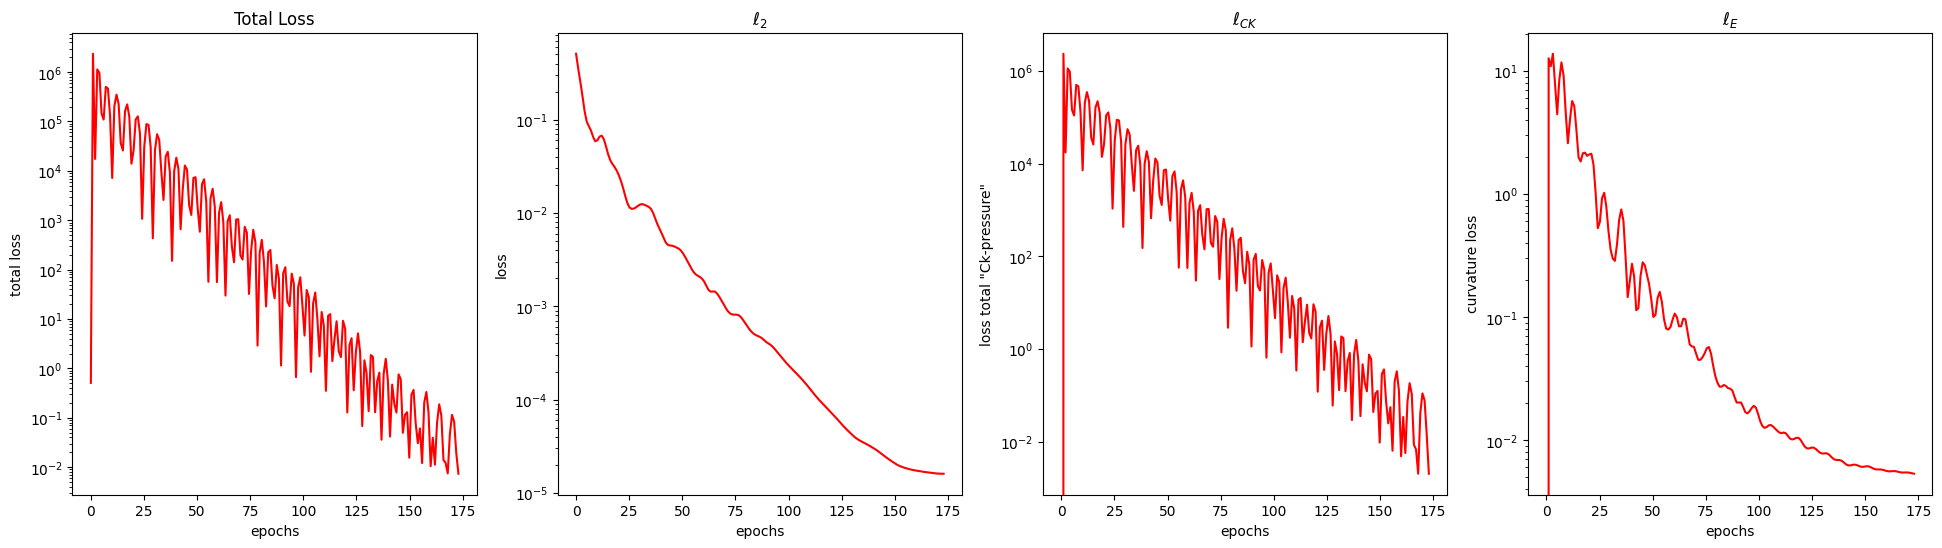

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')
plot.plot_loss(pp, 'all')

In [83]:
pp._establish_continuity()
loss = pp.get_total_loss()

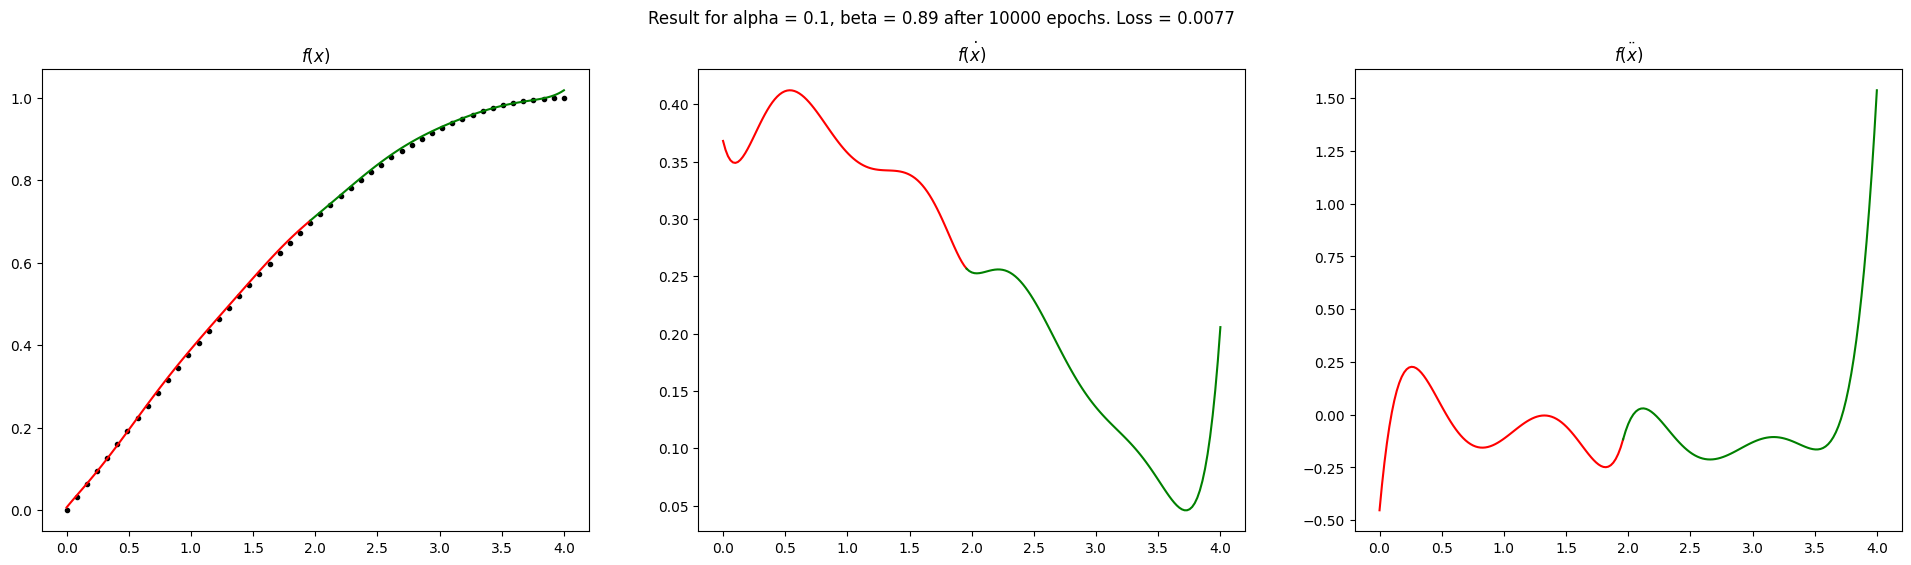

In [84]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')

In [85]:
alpha = 0.1
beta = 0.89
epochs=10000

pp = model.Spline(polydegree=degree, polynum=polynum, ck=ck, basis='chebyshev')
opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate, )

loss = pp.fit(xs2, ys2, optimizer=opt, n_epochs=epochs, factor_ck_pressure=alpha, factor_approximation_quality=beta, factor_curvature=1-alpha-beta, early_stopping=True, patience=1000, ck_regularization=False)

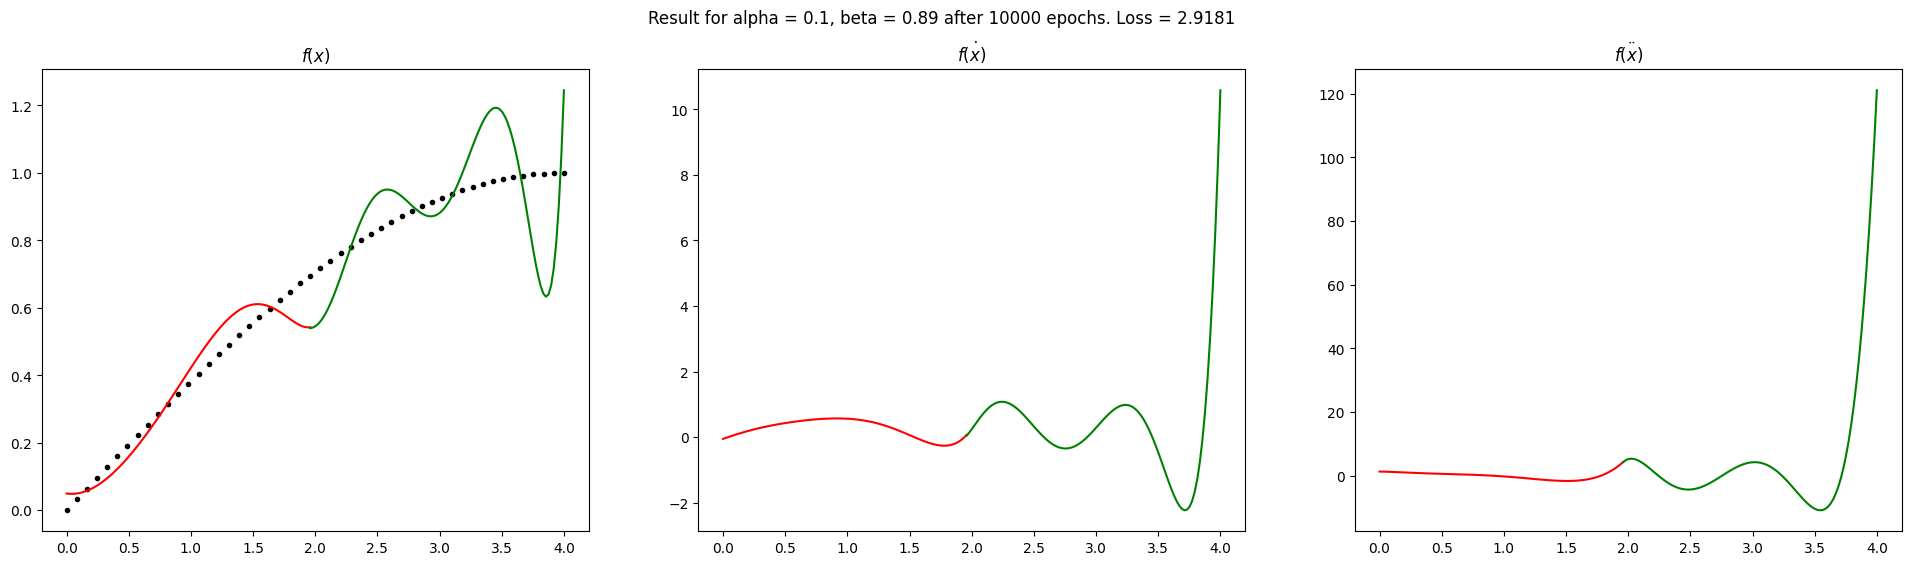

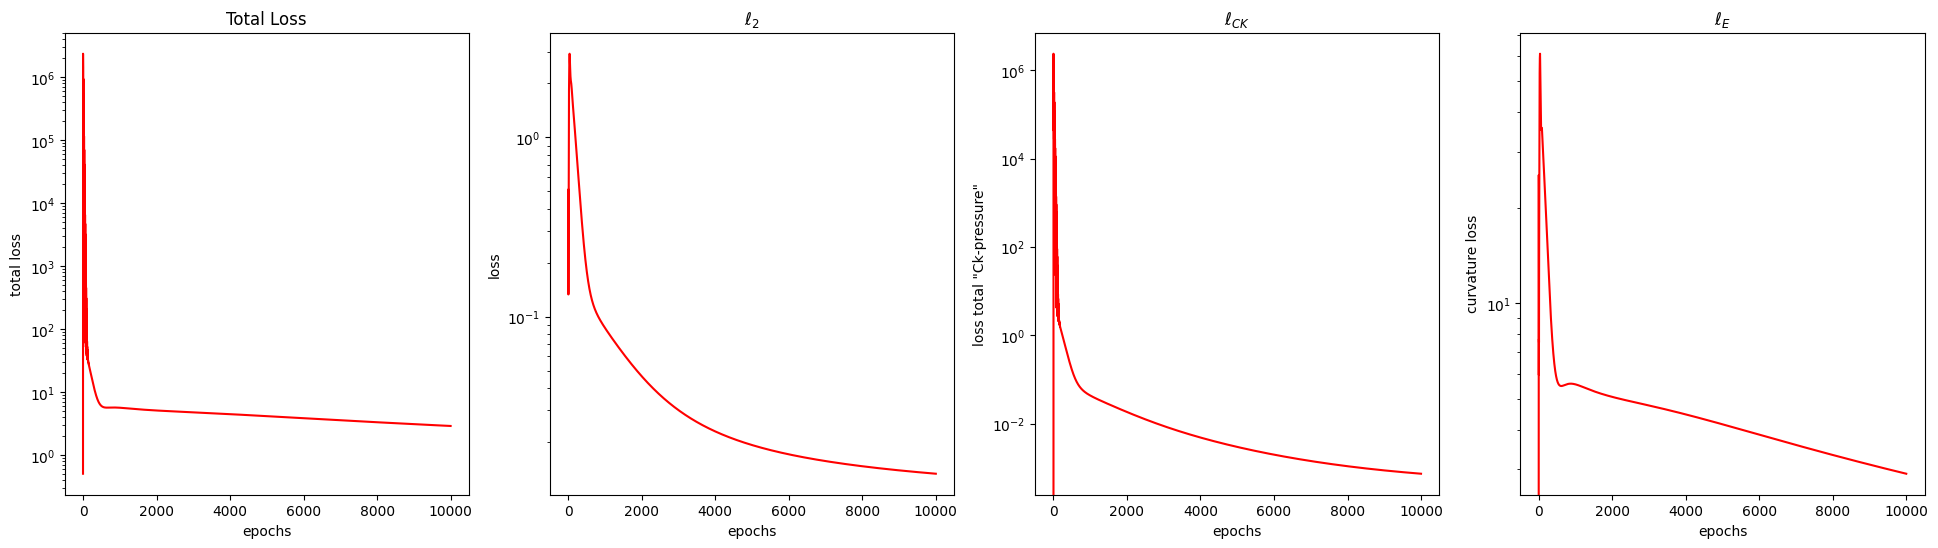

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')
plot.plot_loss(pp, 'all')

In [87]:
pp._establish_continuity()
pp.get_total_loss()

<tf.Tensor: shape=(), dtype=float64, numpy=2.9285694410003096>

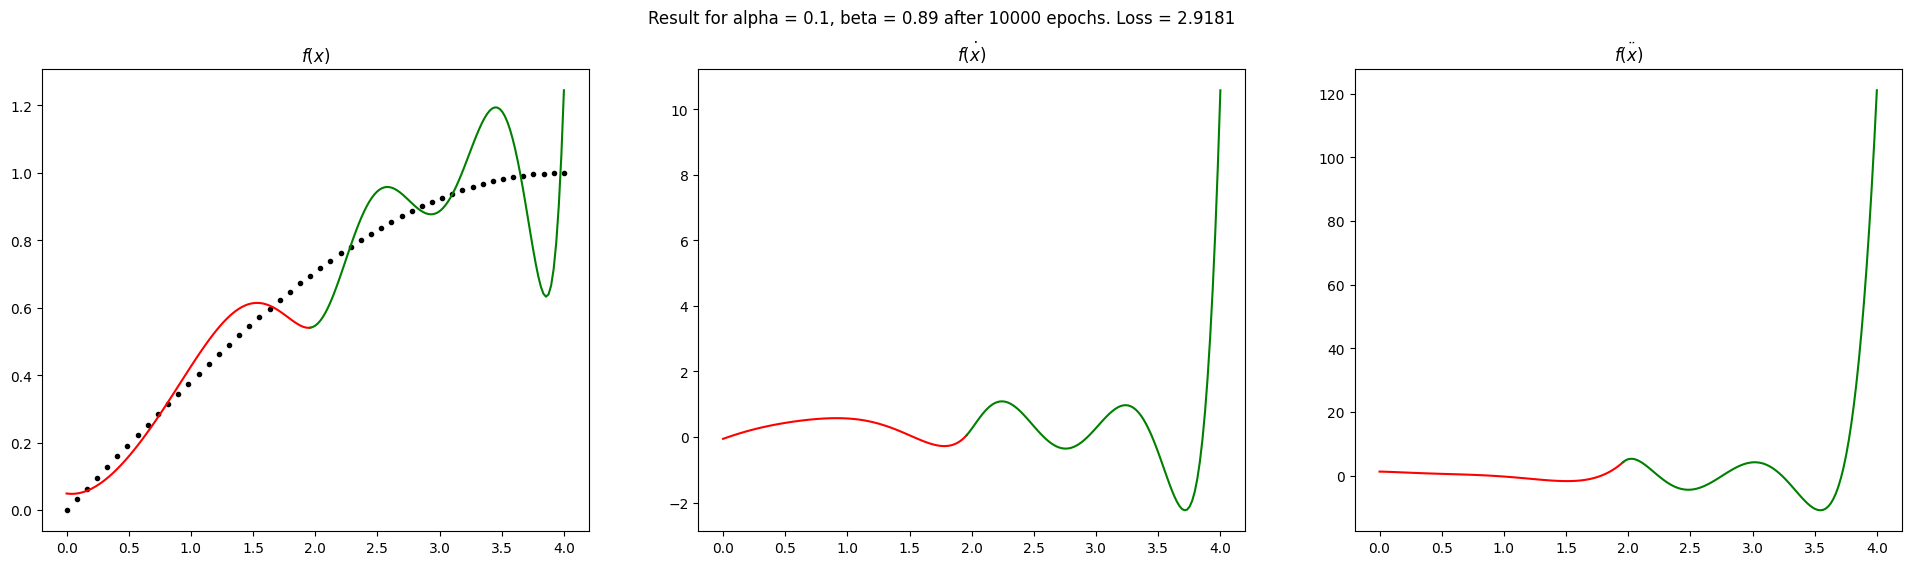

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
fig.set_figwidth(24)
fig.set_figheight(6)
fig.suptitle(f'Result for alpha = {alpha}, beta = {beta} after {epochs} epochs. Loss = {loss:.4f}')

plot.plot_spline(pp, ax=ax1, title='$f(x)$')
plot.plot_spline(pp, deriv=1, ax=ax2, title='$\dot{f(x)}$')
plot.plot_spline(pp, deriv=2, ax=ax3, title='$\ddot{f(x)}$')

### Interpretation

Disabling Ck-regularization is not an option with Chebyshev basis.  
Power basis is preferred for performing $\ell_E$ optimization.  